In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

In [2]:
#loading data (from the official website http://www.cs.toronto.edu/~kriz/cifar.html)
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
def show_image(indx, data):
    imshow(np.stack(data['data'][indx].reshape(3,32,32),axis=2))
    return 

# PyTorch implementation

In [4]:
DATA_PATH = './data/'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [6]:
# check if there is gpu
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


class: automobile


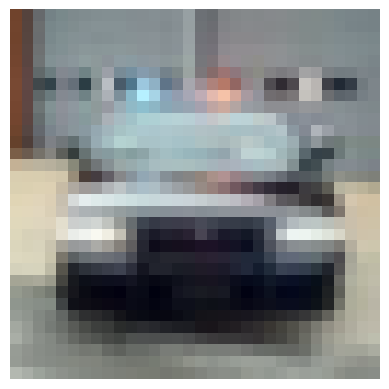

In [27]:
# show images
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'class: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

In [13]:
for i, (x, y) in enumerate(test_loader):
    print(i, x.shape, y)
    break

0 torch.Size([64, 3, 32, 32]) tensor([6, 7, 4, 1, 8, 6, 7, 7, 1, 2, 1, 2, 8, 0, 0, 3, 7, 5, 4, 9, 7, 5, 0, 7,
        4, 8, 5, 4, 0, 4, 8, 8, 8, 5, 3, 3, 7, 0, 3, 0, 4, 5, 2, 4, 9, 2, 0, 3,
        4, 0, 2, 9, 6, 9, 6, 1, 4, 6, 6, 2, 2, 7, 6, 4])


In [47]:
# accuracy
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    loss = [] 
    model.eval() # no training mode, this is for batchnorm that changes depending on the mode
    model = model.to(device=device)
    with torch.no_grad(): # no backward required, so no computational graph is contrcuted
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            logits = model(xi)
            probabilities = F.softmax(logits, dim=1)
            _, pred = probabilities.max(dim=1) 
            num_correct += (pred == yi).sum() 
            num_total += pred.size(0)
            loss.append(F.cross_entropy(input=logits, target=yi).item())
        accuracy = float(num_correct)/num_total  
        loss = np.array(loss).mean()
    return loss, accuracy 

In [43]:
def tenumerate(iterable, **kwargs):
    _enumerate = np.ndenumerate if isinstance(iterable, np.ndarray) else enumerate
    return _enumerate(tqdm(iterable, **kwargs))

In [48]:
# training
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in tenumerate(train_loader):
            model.train() # train mode
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            # print(xi.shape)
            #forward pass
            logits = model(xi)
            loss = F.cross_entropy(input= logits, target=yi)
             #backward pass
            optimiser.zero_grad()           
            loss.backward()
            #update
            optimiser.step()              
            #t.set_description(f'Epoch: {epoch} | loss_train: {loss.item()}')
        loss_train, acc_train = accuracy(model, train_loader)  
        loss_val, acc_val = accuracy(model, val_loader) 
        print(f"Epoch: {epoch}, loss_train: {loss_train}, loss_val: {loss_val}, acc_val: {acc_val}, acc_train: {acc_train}")

In [49]:
# VERSION 1: Linear layer
# there is no notion of space. We just flatten the image and pass it to a sequnce of linear layers

hidden_layer1 = 256
hidden_layer2 = 256

modelLinear = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(in_features = 32 * 32 * 3, out_features=hidden_layer1), 
                            nn.ReLU(),
                            nn.Linear(in_features=hidden_layer1, out_features=hidden_layer2),
                            nn.ReLU(),
                            nn.Linear(in_features=hidden_layer2, out_features=10),
                            nn.ReLU()
                            )

lr = 0.001
epochs = 10
optimiser = torch.optim.Adam(modelLinear.parameters(), lr=lr)


In [50]:
train(modelLinear, optimiser=optimiser, epochs=epochs)

100%|██████████| 782/782 [00:21<00:00, 36.29it/s]


Epoch: 0, loss_train: 1.7892625809020704, loss_val: 1.8129648483252223, acc_val: 0.3836, acc_train: 0.39458


100%|██████████| 782/782 [00:23<00:00, 33.88it/s]


Epoch: 1, loss_train: 1.6586224177609319, loss_val: 1.7203613082064857, acc_val: 0.4116, acc_train: 0.43542


100%|██████████| 782/782 [00:21<00:00, 36.20it/s]


Epoch: 2, loss_train: 1.604919583596232, loss_val: 1.7047699222081825, acc_val: 0.4268, acc_train: 0.45144


100%|██████████| 782/782 [00:20<00:00, 37.40it/s]


Epoch: 3, loss_train: 1.4921675812252952, loss_val: 1.6474935963184019, acc_val: 0.4468, acc_train: 0.49576


100%|██████████| 782/782 [00:20<00:00, 38.03it/s]


Epoch: 4, loss_train: 1.3372367700499952, loss_val: 1.5224562566491622, acc_val: 0.4816, acc_train: 0.53944


100%|██████████| 782/782 [00:20<00:00, 37.65it/s]


Epoch: 5, loss_train: 1.1773270016436077, loss_val: 1.4229916017266768, acc_val: 0.518, acc_train: 0.59466


100%|██████████| 782/782 [00:20<00:00, 37.62it/s]


Epoch: 6, loss_train: 1.0881379415921848, loss_val: 1.3924375425411175, acc_val: 0.52, acc_train: 0.62244


100%|██████████| 782/782 [00:20<00:00, 37.62it/s]


Epoch: 7, loss_train: 1.022408722764086, loss_val: 1.4152805458141278, acc_val: 0.5248, acc_train: 0.64404


100%|██████████| 782/782 [00:22<00:00, 35.19it/s]


Epoch: 8, loss_train: 0.9580243517980551, loss_val: 1.4011329450184786, acc_val: 0.5352, acc_train: 0.67062


100%|██████████| 782/782 [00:20<00:00, 38.50it/s]


Epoch: 9, loss_train: 0.912553585551279, loss_val: 1.451909173138534, acc_val: 0.5346, acc_train: 0.68808


In [51]:
from PIL import Image
def resize_image(image: Image, length: int) -> Image:
    if image.size[0] < image.size[1]:
        # The image is in portrait mode. Height is bigger than width.
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))
        # Amount of pixel to lose in total on the height of the image.
        required_loss = (resized_image.size[1] - length)
        # Crop the height of the image so as to keep the center part.
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))
        # We now have a length*length pixels image.
        return resized_image
    else:
        # This image is in landscape mode or already squared. The width is bigger than the heihgt.
        # This makes the height fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
        # Amount of pixel to lose in total on the width of the image.
        required_loss = resized_image.size[0] - length
        # Crop the width of the image so as to keep 1080 pixels of the center part.
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
        # We now have a length*length pixels image.
        return resized_image

In [52]:
# importing modules
import urllib.request
from PIL import Image
from torchvision import transforms

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# img = resize_image(img, 32)
# imshow(img)
def inference(model, url):
  
    urllib.request.urlretrieve(url, 'tmp.png')
    img = Image.open("tmp.png")
    img = resize_image(img, 32)
    im = transforms.ToTensor()(img)

    model.eval() # evaluation mode
    x = im.to(device=device, dtype=torch.float32)
    x = x.view(1,3,32,32)
    imshow(x[0,0])
    # print(x.shape)
    #forward pass
    with torch.no_grad(): 
        logits = model(x)
        # print(logits.shape)
        probs = F.softmax(logits, dim=-1)[0] # we convert it into a probability
        guess = torch.argmax(probs)
    # print(probs)
    print(f"it's a {classes[guess.item()]} with {probs[guess.item()]:.2f} probability")
    return


In [57]:
# Sequential CNN

ch1 = 16 
ch2 = 32 

modelCNN1 = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=ch1, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=ch1,out_channels=ch2,kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Flatten(),
                        nn.Linear(in_features=16*16*ch2,out_features=10),
                        )

lr = 0.01
epochs = 10
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr=lr)

In [58]:
train(modelCNN1, optimiser=optimiser, epochs=epochs)

100%|██████████| 782/782 [00:56<00:00, 13.76it/s]


Epoch: 0, loss_train: 2.303312462918899, loss_val: 2.3033143719540368, acc_val: 0.0994, acc_train: 0.1


100%|██████████| 782/782 [00:55<00:00, 14.06it/s]


Epoch: 1, loss_train: 2.3032579623219913, loss_val: 2.3025927966154076, acc_val: 0.1014, acc_train: 0.1


100%|██████████| 782/782 [00:50<00:00, 15.41it/s]


Epoch: 2, loss_train: 2.302750750575834, loss_val: 2.3028022699718234, acc_val: 0.0994, acc_train: 0.1


100%|██████████| 782/782 [01:01<00:00, 12.77it/s]


Epoch: 3, loss_train: 2.303299252334458, loss_val: 2.3034218474279475, acc_val: 0.0976, acc_train: 0.1


100%|██████████| 782/782 [00:53<00:00, 14.54it/s]


Epoch: 4, loss_train: 2.3035043118250034, loss_val: 2.3035105964805505, acc_val: 0.1008, acc_train: 0.1


100%|██████████| 782/782 [00:50<00:00, 15.61it/s]


Epoch: 5, loss_train: 2.3033100485496814, loss_val: 2.3035341697403147, acc_val: 0.1026, acc_train: 0.1


 86%|████████▌ | 670/782 [00:45<00:07, 14.60it/s]


KeyboardInterrupt: 

it's a dog with 0.69 probability


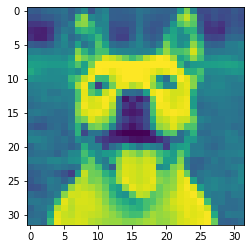

In [146]:
image_url = 'https://ggsc.s3.amazonaws.com/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner.jpg'  
inference(modelCNN1, image_url)